In [ ]:
import numpy as np
import csv
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ***Load Data***

In [ ]:
!gdown --id "1Pu_qb3_j7VZQFIuUWtR0ePpm5yaFgt7y" --output "train.cv"
!gdown --id "1dkX9E7O5aAurdpaqmjfWMQi1mEUV5xOc" --output "test.cv"


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Pu_qb3_j7VZQFIuUWtR0ePpm5yaFgt7y
To: /content/train.cv
100% 18.9k/18.9k [00:00<00:00, 25.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dkX9E7O5aAurdpaqmjfWMQi1mEUV5xOc
To: /content/test.cv
100% 1.81k/1.81k [00:00<00:00, 2.95MB/s]


# ***Loading Data***

In [ ]:
train=pd.read_csv('train.cv')
test=pd.read_csv('test.cv')
#d = pd.concat(map(pd.read_csv, ['train.cv', 'test.cv']), ignore_index=True)
d=pd.read_csv('train.cv', index_col='Date')
#e=pd.read_csv('test.cv', index_col='Date')
df=pd.DataFrame(d)
arima_data = df["Close"]
#df_test=pd.DataFrame(e)
#arima_test=df_test["Close"]

# ***Visualization***

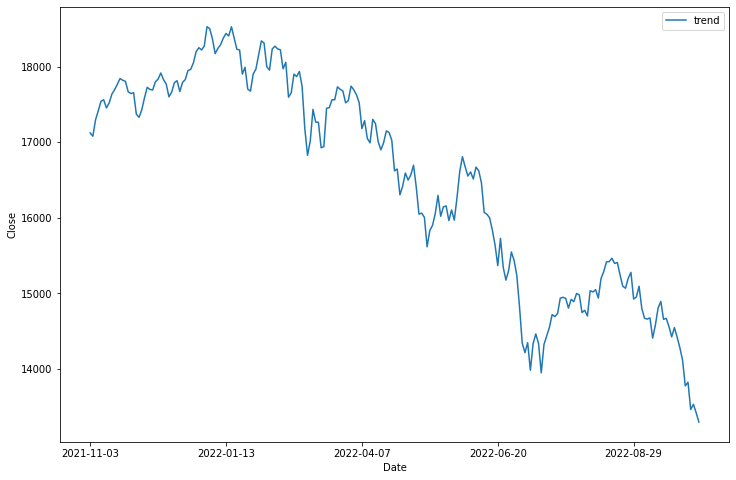

In [ ]:
arima_data.plot(figsize=(12,8), label='trend')
plt.ylabel("Close")
plt.legend()
plt.show()

# ***ETS Decomposition Models(error-trend-seasonality)***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


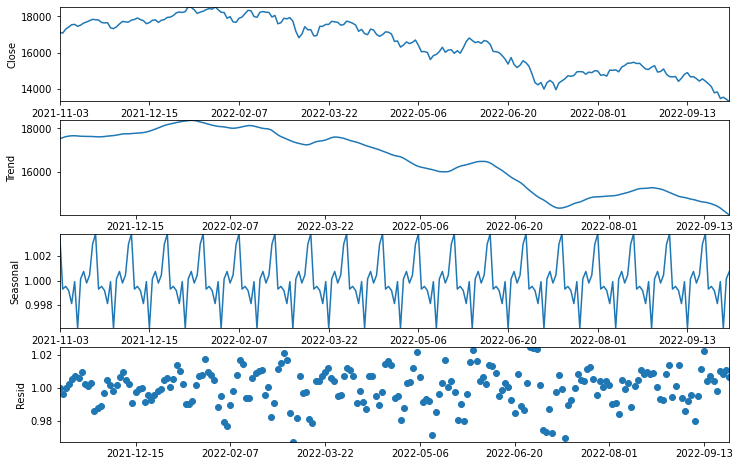

In [ ]:
#ETS可將時間序列資料拆成：趨勢、季節性和殘差，讓我們更了解欲分析的資料特性
result = seasonal_decompose(arima_data, model="multiplicative", freq=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot( result.observed, label="Close value")
plt.ylabel("Close")
plt.xticks(df.index[::30], rotation=0) #調整x軸刻度的呈現(每隔30天)
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(df.index[::30], rotation=0)
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(df.index[::30], rotation=0)
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df.index,result.resid);
plt.ylabel("Resid")
plt.xticks(df.index[::30], rotation=0)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

# ***平穩性檢驗***

In [ ]:
#時間序列的資料再跑統計模型前，先做平穩性檢驗，來判斷資料是否平穩(stationary)，如果不平穩，要做差分處理。
#Dickey Fuller test:如果檢驗統計量小於臨界值，我們可以拒絕原假設(也就是序列是平穩的)。 當檢驗統計量大於臨界值時，無法拒絕原假設(這意味著序列不是平穩的)。
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")
    #自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)")
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                   0.296756
p-value                          0.977195
#Lags Used                       0.000000
Number of Observations Used    224.000000
Criterical Value (1%)           -3.459885
Criterical Value (5%)           -2.874531
Criterical Value (10%)          -2.573694
dtype: float64
The data is non-stationary, so do differencing!


# ***若不平穩，做差分***

Results of Dickey-Fuller Test
Test Statistic                -1.411743e+01
p-value                        2.458503e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.230000e+02
Criterical Value (1%)         -3.460019e+00
Criterical Value (5%)         -2.874590e+00
Criterical Value (10%)        -2.573725e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


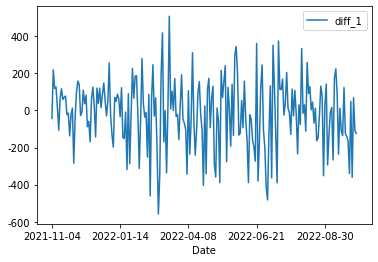

In [ ]:
#一階差分 lags:1,12
diff_1 = arima_data - arima_data.shift(1)
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(6,4), label="diff_1")
plt.legend();

adf_test(diff_1)

# ***畫ACF圖與PACF圖***

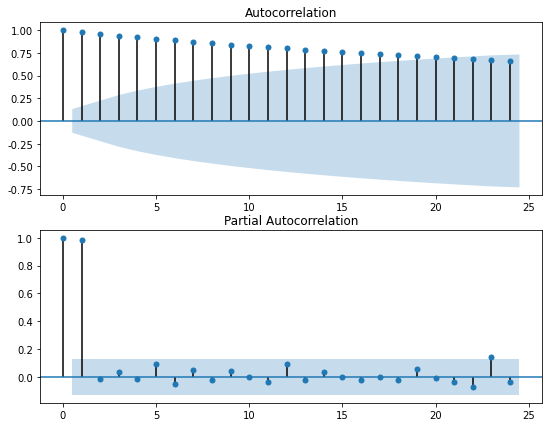

In [ ]:
#畫ACF(Autocorrelation Function)、PACF(Partial Autocorrelation Function)圖可幫助我們判斷模型ARIMA(p, d, q)參數的選擇。
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1);
ax2 = f.add_subplot(212);
plot_pacf(arima_data, lags=24, ax=ax2);
plt.rcParams['axes.unicode_minus'] = False
plt.show()


# ***樣本內預測模型建立***

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

ARIMA(0,1,0)：AIC=2973.6573064561912
ARIMA(0,1,1)：AIC=2974.985256238429
ARIMA(0,1,2)：AIC=2975.846016494075
ARIMA(1,1,0)：AIC=2975.0795005797345
ARIMA(1,1,1)：AIC=2976.2528653700338
ARIMA(1,1,2)：AIC=2977.583736122524


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(2,1,0)：AIC=2975.853352947194
ARIMA(2,1,1)：AIC=2977.4811061437204


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(2,1,2)：AIC=2979.0413403312505
ARIMA(3,1,0)：AIC=2977.5645231839135


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(3,1,1)：AIC=2978.9078082332476


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(3,1,2)：AIC=2981.394937243582
This best model is ARIMA(0,1,0) based on argmin AIC.


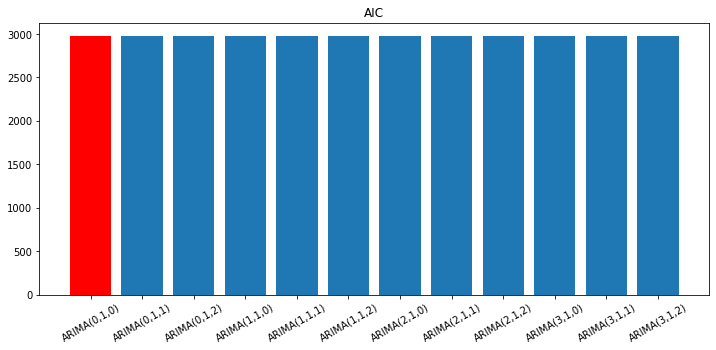

In [ ]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit(disp=-1)
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k})：AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.savefig("Arima AIC")
    plt.show()
arima_AIC(arima_data, 4,2,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

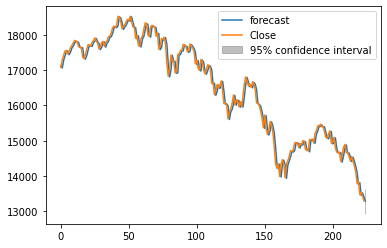

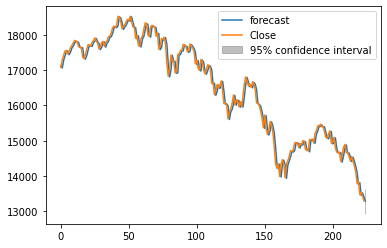

In [ ]:
model = ARIMA(arima_data, order=(0, 1, 0)) #修改 p,d,q參數
fitted = model.fit(disp=-1)
fitted.plot_predict(1,len(df))

# ***樣本外預測模型建立：預測2022下一個月的close***

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

ARIMA(0,1,0)：MSE=350578.1327515303
ARIMA(0,1,1)：MSE=334112.5837392763
ARIMA(0,1,2)：MSE=350642.8109563225
ARIMA(1,1,0)：MSE=336701.37392940145
ARIMA(1,1,1)：MSE=339024.2368388583
ARIMA(1,1,2)：MSE=358770.36566323205


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

ARIMA(2,1,0)：MSE=344997.44923590485
ARIMA(2,1,1)：MSE=357273.39758474444


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

ARIMA(2,1,2)：MSE=382161.7455369338
This best model is pdq based on argmin MSE.


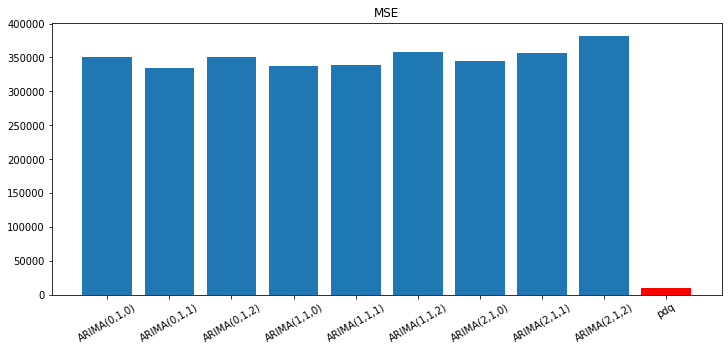

In [ ]:
def arima_mse(data, p=4, d=3, q=4):
    period = 21 #預測21天
    best_pdq =["pdq",10000]
    L =len(data)
    train = data[:(L-period)]
    test = data[-period:]
    mse_r = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):
                model = ARIMA(train, order=(i,j,k))
                fitted = model.fit(disp=-1)
                fc, se, conf = fitted.forecast(period, alpha=0.05)
                mse = mean_squared_error(test,fc)
                mse_r.append(mse)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k})：MSE={mse}")
                if mse < best_pdq[1]:
                    best_pdq[0] = f"ARIMA({i},{j},{k})"
                    best_pdq[1] = mse
    print("==========================================================================")
    print(f"This best model is {best_pdq[0]} based on argmin MSE.")
    plt.figure(figsize=(12,5))
    plt.bar(name, mse_r)
    plt.bar(best_pdq[0], best_pdq[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("MSE")
    plt.savefig("Arima MSE")
    plt.show()
arima_mse(arima_data, 3,2,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

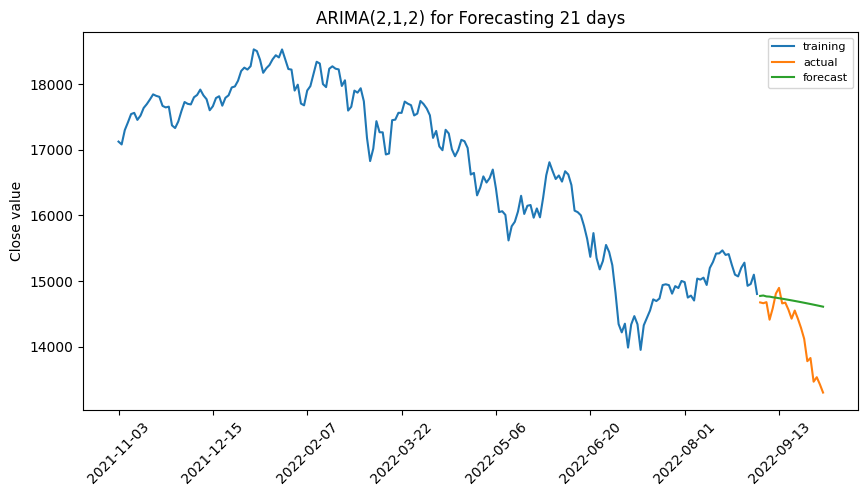

Mean Absolute Error : 448.35790342376083
Mean Squared Error : 382161.7455369338
fc_series: Date
2022-09-02    14771.816116
2022-09-05    14778.308182
2022-09-06    14764.436836
2022-09-07    14761.285628
2022-09-08    14751.893785
2022-09-12    14745.535092
2022-09-13    14737.157373
2022-09-14    14729.530875
2022-09-15    14721.153991
2022-09-16    14712.857438
2022-09-19    14704.198012
2022-09-20    14695.427814
2022-09-21    14686.418949
2022-09-22    14677.250713
2022-09-23    14667.888965
2022-09-26    14658.361217
2022-09-27    14648.661034
2022-09-28    14638.800248
2022-09-29    14628.780453
2022-09-30    14618.608578
2022-10-03    14608.288393
dtype: float64
Close value: Date
2022-09-02    14673.040039
2022-09-05    14661.099609
2022-09-06    14677.200195
2022-09-07    14410.049805
2022-09-08    14583.419922
2022-09-12    14807.429688
2022-09-13    14894.410156
2022-09-14    14658.309570
2022-09-15    14670.040039
2022-09-16    14561.759766
2022-09-19    14425.679688
2022-09

In [ ]:
#data spilt
period = 21
title = f'ARIMA(2,1,2) for Forecasting {period} days'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model
model = ARIMA(x_train, order=(2, 1, 2))
fitted = model.fit(disp=-1)
#Forecast
fc, se, conf = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(df.index[::30], rotation=45)
plt.title(title)
plt.ylabel("Close value")
plt.legend(loc='upper right', fontsize=8)
plt.savefig(title)
plt.show()
#Results
print(f"Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}")
print(f"Mean Squared Error : {mean_squared_error(fc_series,x_test)}")
print("===========================")
print("fc_series:",fc_series)
print("===========================")
print("Close value:",x_test)